### Agrupamento de fundos imobiliarios

In [3]:
import pandas as pd
import locale
import numpy as np
df = pd.read_csv('ranking_funds_2019_11_20.csv', decimal=",")
df.head()

,CÓDIGO DO FUNDO,SETOR,PREÇO ATUAL,LIQUIDEZ DIÁRIA,DIVIDENDO,DIVIDEND YIELD,DY (3M) ACUMULADO,DY (6M) ACUMULADO,DY (12M) ACUMULADO,DY (3M) MÉDIA,...,PATRIMÔNIO LÍQ.,VPA,P/VPA,DY PATRIMONIAL,VARIAÇÃO PATRIMONIAL,RENTAB. PATR. NO PERÍODO,RENTAB. PATR. ACUMULADA,VACÂNCIA FÍSICA,VACÂNCIA FINANCEIRA,QUANTIDADE ATIVOS
0,ABCP11,Shoppings,"R$ 100,00",3205.0,"R$ 0,49","0,52%","1,56%","2,82%","5,88%","0,52%",...,"R$ 910.755.024,13","R$ 74,63",1.34,"0,66%","0,13%","0,79%","436,66%","0,90%",NaN,1
1,ALMI11,Lajes Corporativas,"R$ 1.412,97",38.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 190.562.339,38","R$ 1.714,04",0.82,NaN,NaN,NaN,NaN,"82,00%",NaN,1
2,ALZR11,Logística,"R$ 112,40",18087.0,"R$ 0,55","0,48%","1,37%","2,84%","6,90%","0,46%",...,"R$ 270.782.271,29","R$ 94,65",1.19,"0,58%","0,03%","0,61%","2,62%","0,00%",NaN,6
3,ATSA11,Shoppings,"R$ 131,00",5.0,"R$ 0,25","0,19%","0,86%","1,90%","2,73%","0,29%",...,"R$ 185.572.969,42","R$ 108,19",1.21,"0,23%","0,04%","0,27%","2,64%","18,90%",NaN,1
4,BARI11,Títulos e Val. Mob.,"R$ 110,00",2017.0,"R$ 1,11","1,00%","2,86%","0,00%","0,00%","0,95%",...,"R$ 72.948.682,30","R$ 99,36",1.11,"1,12%","-0,62%","0,50%","2,63%",NaN,NaN,0


#### Removendo variaveis muito correlacionadas

In [133]:
df.columns = [str.replace('\n', ' ') for str in df.columns]
df_variaveis = df.drop(['CÓDIGO DO FUNDO', 'SETOR'], axis = 1)
locale.setlocale(locale.LC_NUMERIC, '')
df_variaveis = df_variaveis.replace(r'[R\$ %\n]', '', regex = True).astype(str).applymap(locale.atof)
df_full = df_variaveis.copy()
corr_matrix = df_variaveis.corr().abs()
corr_matrix = df_variaveis.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
df_variaveis = df_variaveis.drop(df_variaveis[to_drop + ['PREÇO ATUAL', 'VARIAÇÃO PREÇO', 'VACÂNCIA FÍSICA', 'VARIAÇÃO PATRIMONIAL']], axis=1).fillna(0)
df_variaveis.head()

,LIQUIDEZ DIÁRIA,DIVIDEND YIELD,DY (3M) ACUMULADO,RENTAB. ACUMULADA,PATRIMÔNIO LÍQ.,P/VPA,RENTAB. PATR. ACUMULADA,QUANTIDADE ATIVOS
0,32050.0,0.52,1.56,14.71,9.107550e+08,134.0,436.66,1.0
1,380.0,0.00,0.00,-28.29,1.905623e+08,82.0,0.00,1.0
2,180870.0,0.48,1.37,22.69,2.707823e+08,119.0,2.62,6.0
3,50.0,0.19,0.86,33.75,1.855730e+08,121.0,2.64,1.0
4,20170.0,1.00,2.86,17.06,7.294868e+07,111.0,2.63,0.0


#### Padronização do tamanho dos eixos

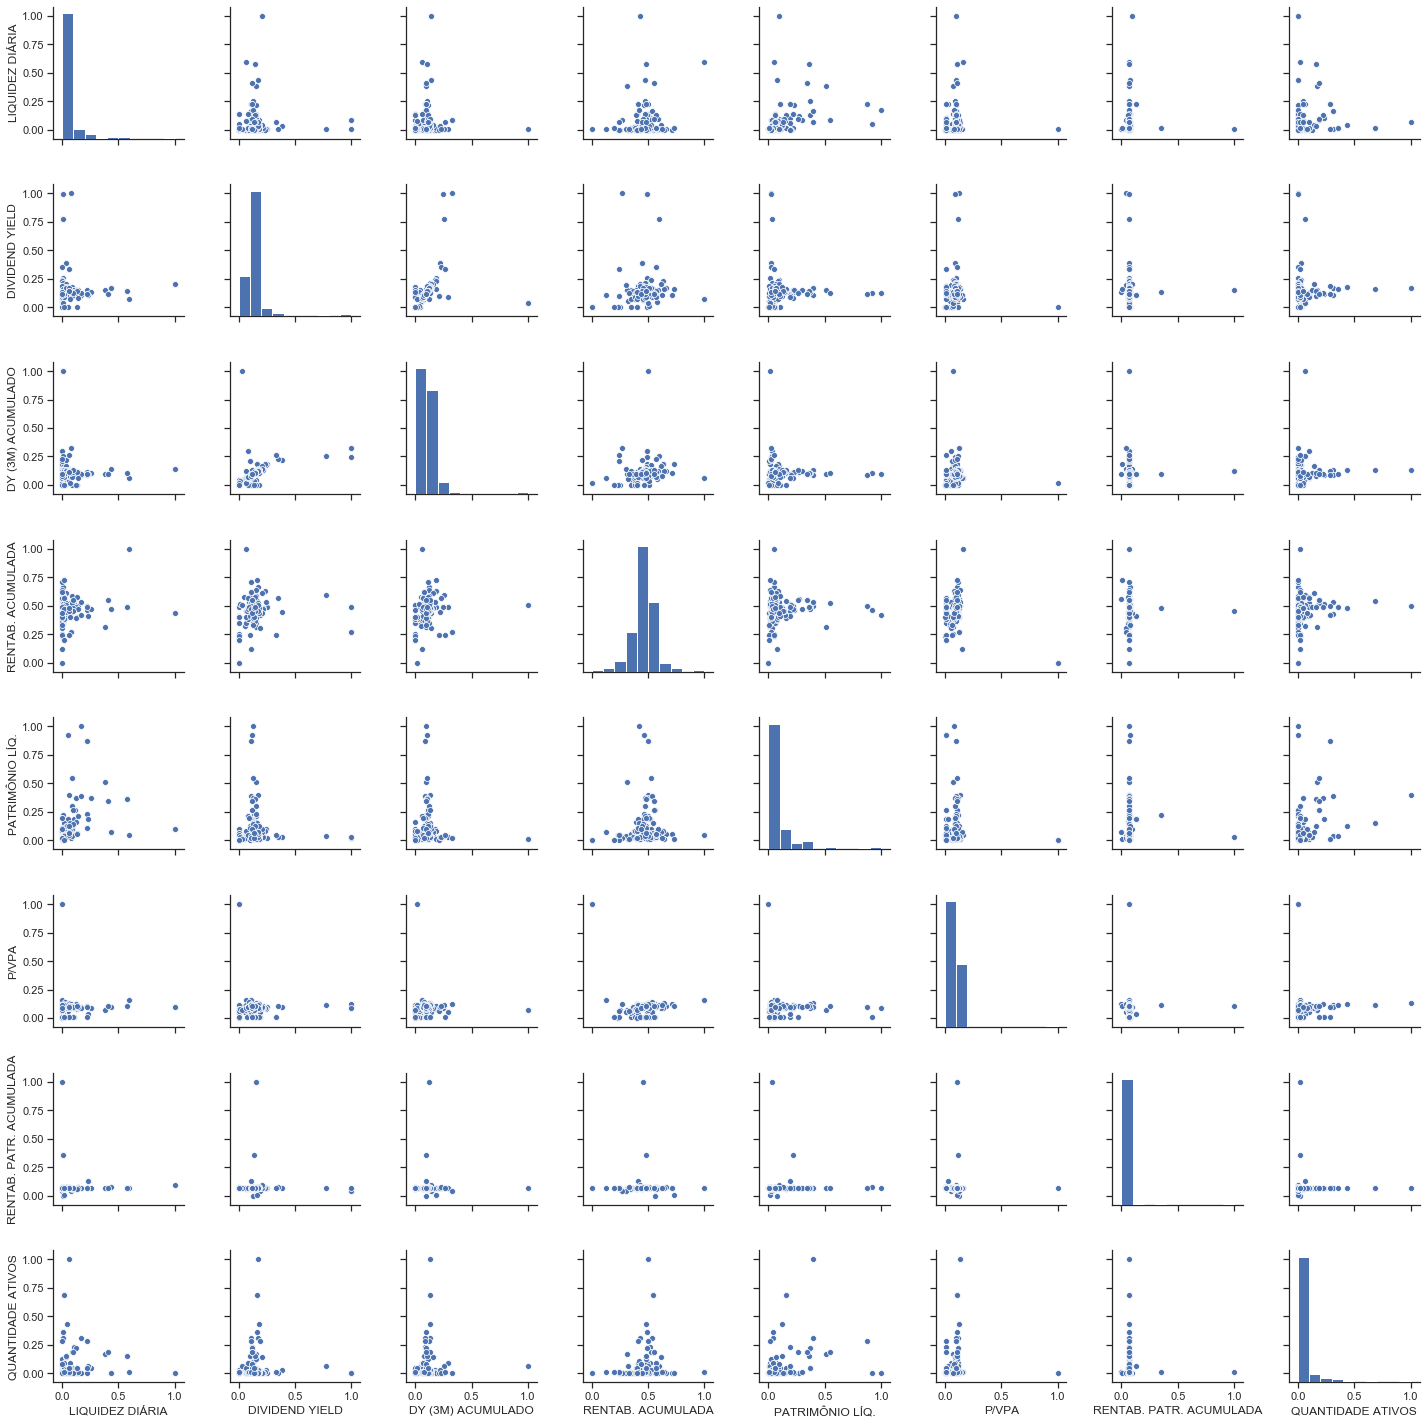

In [5]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns; sns.set(style="ticks", color_codes=True)
scaler = MinMaxScaler().fit(df_variaveis)
X = pd.DataFrame(scaler.transform(df_variaveis), columns = df_variaveis.columns)
gr = sns.pairplot(X)

#### Remoção de outliers

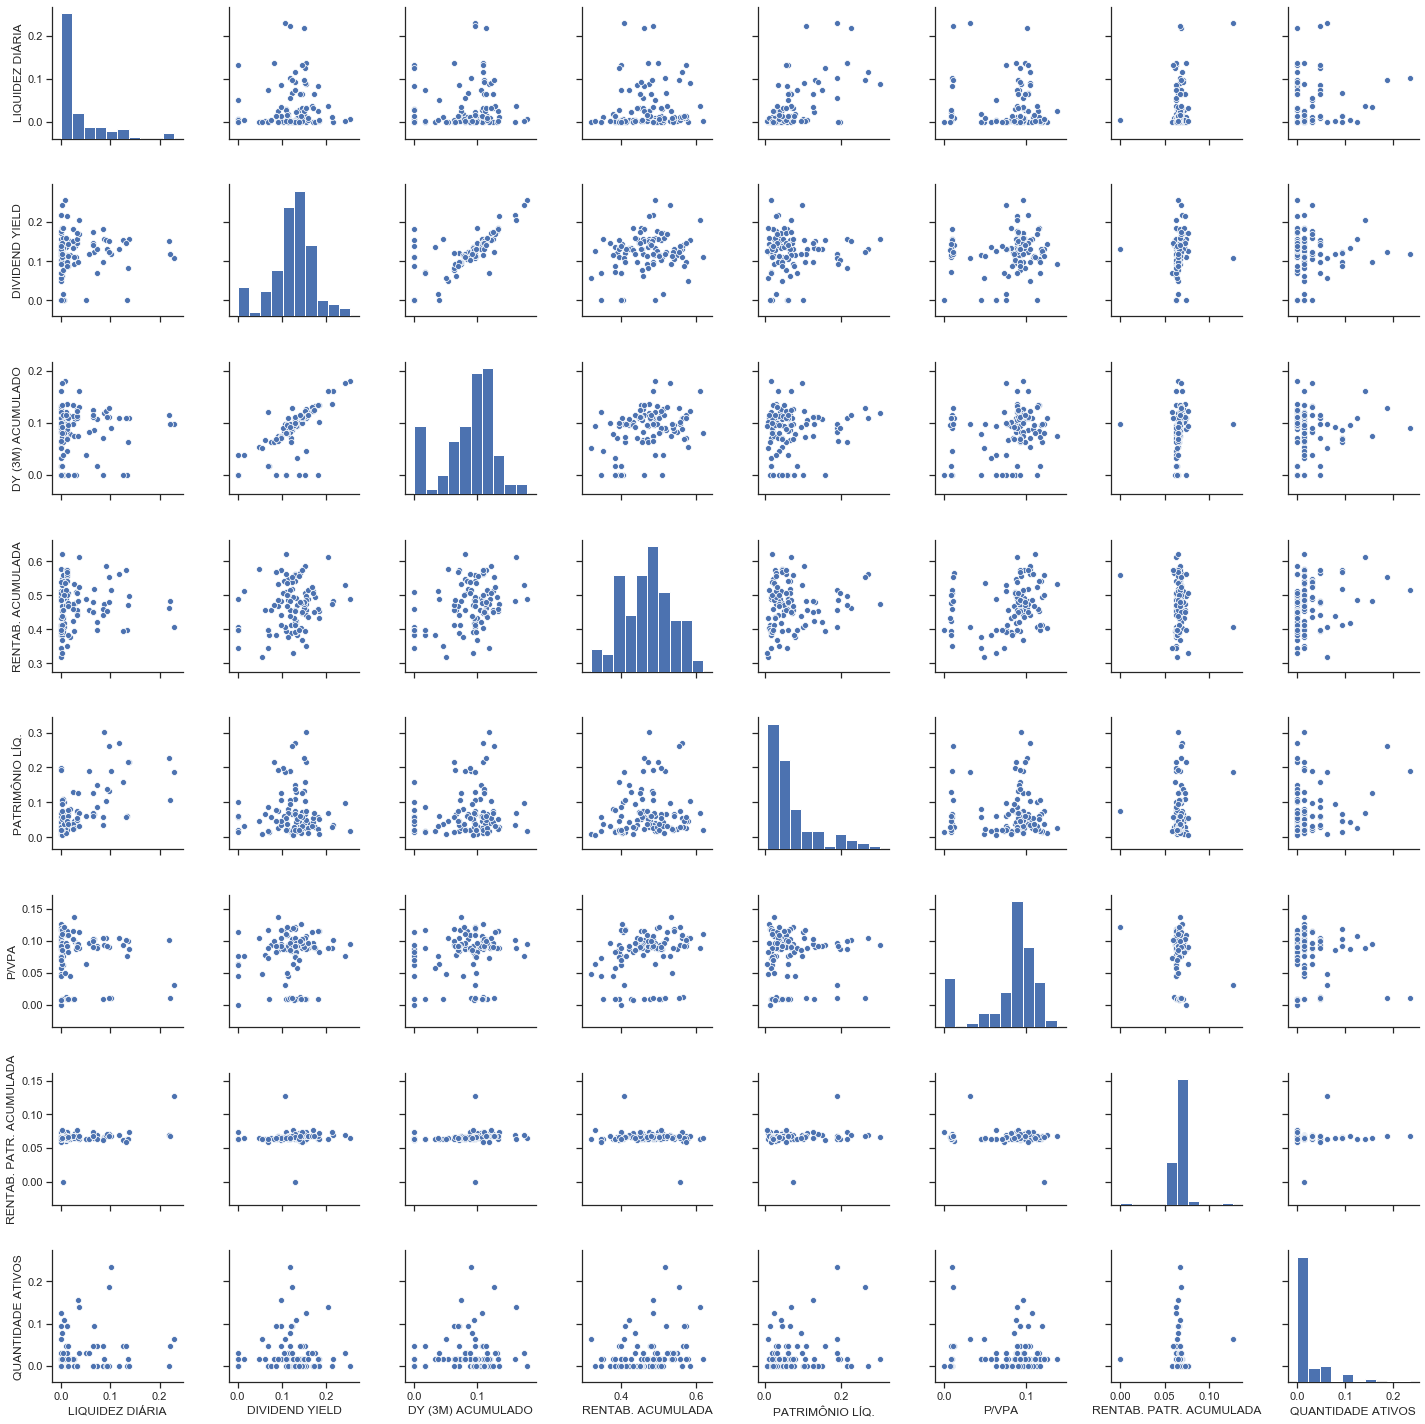

In [6]:
from scipy import stats
X_tr = X[(np.abs(stats.zscore(X)) < 1.5).all(axis=1)]
gr = sns.pairplot(X_tr)

#### PCA

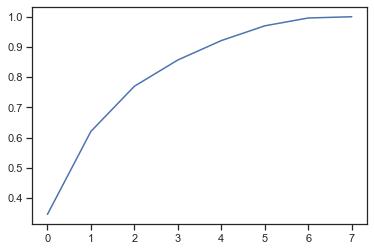

<Figure size 432x288 with 0 Axes>

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA().fit(X_tr)
X_pca = pd.DataFrame(pca.transform(X_tr), index = X_tr.index)
sns.lineplot(data = pca.explained_variance_ratio_.cumsum())
fig = plt.figure()

#### kmeans

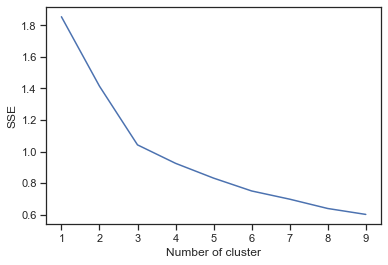

In [8]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
#X_tr = X_tr.reset_index()
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_tr)
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(X_tr)
X_tr["clusters"] = kmeans.labels_
X_tr.head()

,LIQUIDEZ DIÁRIA,DIVIDEND YIELD,DY (3M) ACUMULADO,RENTAB. ACUMULADA,PATRIMÔNIO LÍQ.,P/VPA,RENTAB. PATR. ACUMULADA,QUANTIDADE ATIVOS,clusters
2,0.066535,0.122449,0.086381,0.519374,0.066208,0.102763,0.064831,0.093750,0
3,0.000018,0.048469,0.054224,0.578079,0.045365,0.104491,0.064844,0.015625,0
4,0.007420,0.255102,0.180328,0.489490,0.017817,0.095855,0.064837,0.000000,0
5,0.001151,0.242347,0.175914,0.529246,0.097751,0.075993,0.068922,0.031250,0
8,0.012077,0.155612,0.046658,0.350372,0.038106,0.009499,0.063085,0.015625,1


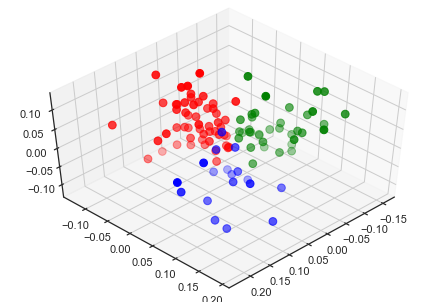

In [10]:
fig = plt.figure()
ax = Axes3D(fig)
lista_cluster = ['red', 'green', 'blue']
for cluster in range(0,len(lista_cluster)):
    ax.scatter(X_pca[X_tr.clusters == cluster].iloc[:,0], 
               X_pca[X_tr.clusters == cluster].iloc[:,1], 
               X_pca[X_tr.clusters == cluster].iloc[:,2], 
               c=lista_cluster[cluster], s=60)
ax.view_init(50, 45)
plt.show()

#### Radar 

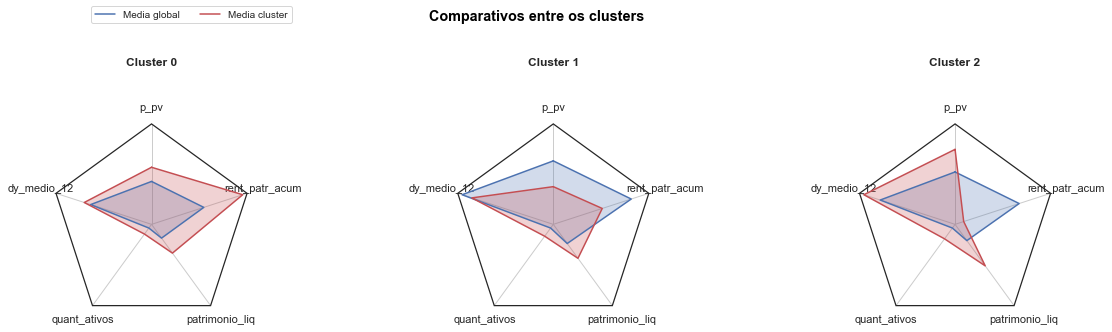

In [221]:
import radar

df_variaveis = df_variaveis.reset_index().set_index('index')
X_p = (pd.merge(X_tr.reset_index().set_index('index'), 
          df_full.reset_index().set_index('index'), how='inner', 
          left_on='index', right_on='index').fillna(0).loc[:,
                                                           ['DY (12M) MÉDIA', 
                                                            'P/VPA_y', 
                                                            'QUANTIDADE ATIVOS_y', 
                                                            'PATRIMÔNIO LÍQ._y', 
                                                            'RENTAB. PATR. ACUMULADA_y',
                                                            'clusters']]).reset_index()

X_p.columns = ['index','p_pv', 'dy_medio_12', 'quant_ativos', 'patrimonio_liq', 'rent_patr_acum','clusters']
for i in range(1, X_p.shape[1]-1):
    minimo = np.min(X_p.iloc[:,i])
    maximo = np.max(X_p.iloc[:,i])
    X_p.iloc[:,i] = X_p.iloc[:,i].apply(lambda x: (x-minimo)/(maximo-minimo))
medios = [X_p['p_pv'].mean(), 
          X_p['dy_medio_12'].mean(), 
          X_p['quant_ativos'].mean(), 
          X_p['patrimonio_liq'].mean(), 
          X_p['rent_patr_acum'].mean()]
def escalar_coluna(X_p, coluna, cluster):
    minimo = np.min(X_p.loc[X_p.clusters == cluster, coluna])
    maximo = np.max(X_p.loc[X_p.clusters == cluster, coluna])
    X_p.loc[X_p.clusters == cluster, coluna] = (X_p.loc[X_p.clusters == cluster, coluna]
                                                .apply(lambda x: (x-minimo)/(maximo-minimo)))
[escalar_coluna(X_p, coluna, 0) for coluna in ['p_pv','dy_medio_12', 'quant_ativos', 'patrimonio_liq', 'rent_patr_acum']]
medios_0 = [X_p.loc[X_p.clusters == 0, 'p_pv'].mean(), 
            X_p.loc[X_p.clusters == 0,'dy_medio_12'].mean(), 
            X_p.loc[X_p.clusters == 0,'quant_ativos'].mean(), 
            X_p.loc[X_p.clusters == 0,'patrimonio_liq'].mean(), 
            X_p.loc[X_p.clusters == 0,'rent_patr_acum'].mean()]
[escalar_coluna(X_p, coluna, 1) for coluna in ['p_pv','dy_medio_12', 'quant_ativos', 'patrimonio_liq', 'rent_patr_acum']]
medios_1 = [X_p.loc[X_p.clusters == 1, 'p_pv'].mean(), 
            X_p.loc[X_p.clusters == 1,'dy_medio_12'].mean(), 
            X_p.loc[X_p.clusters == 1,'quant_ativos'].mean(), 
            X_p.loc[X_p.clusters == 1,'patrimonio_liq'].mean(), 
            X_p.loc[X_p.clusters == 1,'rent_patr_acum'].mean()]
[escalar_coluna(X_p, coluna, 2) for coluna in ['p_pv','dy_medio_12', 'quant_ativos', 'patrimonio_liq', 'rent_patr_acum']]
medios_2 = [X_p.loc[X_p.clusters == 2, 'p_pv'].mean(), 
            X_p.loc[X_p.clusters == 2,'dy_medio_12'].mean(), 
            X_p.loc[X_p.clusters == 2,'quant_ativos'].mean(), 
            X_p.loc[X_p.clusters == 2,'patrimonio_liq'].mean(), 
            X_p.loc[X_p.clusters == 2,'rent_patr_acum'].mean()]

data = [
    ['p_pv', 'dy_medio_12', 'quant_ativos', 'patrimonio_liq', 'rent_patr_acum'],
    ('Cluster 0', [
        medios,
        medios_0
        ]),
    ('Cluster 1', [
        medios,
        medios_1
        ]),
    ('Cluster 2', [
        medios,
        medios_2
        ]),      
]

N = 5
theta =radar.radar_factory(N, frame='polygon')

data = data
spoke_labels = data.pop(0)

fig, axes = plt.subplots(figsize=(18, 9), nrows=1, ncols=3,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=1, hspace=1, top=1.3, bottom=0.0)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axes.flat, data):
    ax.set_rgrids([])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.3),
                 horizontalalignment='center', verticalalignment='top')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
ax = axes[0]
labels = ('Media global', 'Media cluster',)
legend = ax.legend(labels, loc=(0.2, 1.5),
                   labelspacing=0.1, fontsize='small', ncol=5)

fig.text(0.5, 0.965, 'Comparativos entre os clusters',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()